In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [2]:
import argparse
import collections
import logging
import math
import os,sys,time
import random
from sys import maxsize

import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 

from util.general import init_logger, make_sure_path_exists
from util.myaegan import AeGAN
from util.TrainRoutine import AutoEncTrainRoutine
from util.missingprocessor import Processor


/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
poll = 2

In [4]:
data_path = f"data/poll{poll}_normal_train_180.csv"
loc="mitbih"
seq_len = 180
df = pd.read_csv('{}'.format(data_path), sep = ",", index_col=0)
types = ["continuous" for i in range(len(df.columns))]

P = Processor(types)
# Flip the data to make chronological data
ori_data = P.fit_transform(df)
ori_data = np.expand_dims(ori_data, axis=-1)   
temp_data = [seq for seq in ori_data]
P.dim = 1

from fastNLP import DataSet
dataset = DataSet({"seq_len": [seq_len] * len(temp_data), "dyn": temp_data, "sta":[0]*len(temp_data)})
dic = {
    "train_set": dataset,
    "dynamic_processor": P,
    "static_processor": Processor([])
}
print(P.dim, len(temp_data))
make_sure_path_exists("./data")


t_0 1 None continuous
t_1 1 None continuous
t_2 1 None continuous
t_3 1 None continuous
t_4 1 None continuous
t_5 1 None continuous
t_6 1 None continuous
t_7 1 None continuous
t_8 1 None continuous
t_9 1 None continuous
t_10 1 None continuous
t_11 1 None continuous
t_12 1 None continuous
t_13 1 None continuous
t_14 1 None continuous
t_15 1 None continuous
t_16 1 None continuous
t_17 1 None continuous
t_18 1 None continuous
t_19 1 None continuous
t_20 1 None continuous
t_21 1 None continuous
t_22 1 None continuous
t_23 1 None continuous
t_24 1 None continuous
t_25 1 None continuous
t_26 1 None continuous
t_27 1 None continuous
t_28 1 None continuous
t_29 1 None continuous
t_30 1 None continuous
t_31 1 None continuous
t_32 1 None continuous
t_33 1 None continuous
t_34 1 None continuous
t_35 1 None continuous
t_36 1 None continuous
t_37 1 None continuous
t_38 1 None continuous
t_39 1 None continuous
t_40 1 None continuous
t_41 1 None continuous
t_42 1 None continuous
t_43 1 None continuou

In [5]:
temp_data[0].shape

(180, 1)

In [6]:
DEBUG_SCALE = 512
# ===-----------------------------------------------------------------------===
# Argument parsing
# ===-----------------------------------------------------------------------===
parser = argparse.ArgumentParser()
parser.add_argument("--dataset", default="mitbih", dest="dataset", help=".pkl file to use")                  
parser.add_argument("--devi", default="0", dest="devi", help="gpu")
parser.add_argument("--epochs", default=1000, dest="epochs", type=int,
                    help="Number of full passes through training set for autoencoder")
parser.add_argument("--iterations", default=10000, dest="iterations", type=int,
                    help="Number of iterations through training set for WGAN")
parser.add_argument("--d-update", default=5, dest="d_update", type=int,
                    help="discriminator updates per generator update")
parser.add_argument("--log-dir", default="../stock_result", dest="log_dir",
                    help="Directory where to write logs / serialized models")
parser.add_argument("--task-name", default=time.strftime("%Y-%m-%d-%H-%M-%S"), dest="task_name",
                    help="Name for this task, use a comprehensive one")
parser.add_argument("--python-seed", dest="python_seed", type=int, default=random.randrange(maxsize),
                    help="Random seed of Python and NumPy")
parser.add_argument("--debug", dest="debug", default=False, action="store_true", help="Debug mode")
parser.add_argument("--eval-ae", dest="eval_ae", default=False, action="store_true", help="evaluate autoencoder")
parser.add_argument("--fix-ae", dest="fix_ae", default=None, help="Test mode")
parser.add_argument("--fix-gan", dest="fix_gan", default=None, help="Test mode")
parser.add_argument("--ae-batch-size", default=256, dest="ae_batch_size", type=int,
                    help="Minibatch size for autoencoder")
parser.add_argument("--gan-batch-size", default=256, dest="gan_batch_size", type=int,
                    help="Minibatch size for WGAN")
parser.add_argument("--embed-dim", default=32, dest="embed_dim", type=int, help="dim of hidden state")
parser.add_argument("--hidden-dim", default=32, dest="hidden_dim", type=int, help="dim of GRU hidden state")
parser.add_argument("--layers", default=3, dest="layers", type=int, help="layers")
parser.add_argument("--ae-lr", default=1e-3, dest="ae_lr", type=float, help="autoencoder learning rate")
parser.add_argument("--weight-decay", default=0, dest="weight_decay", type=float, help="weight decay")
parser.add_argument("--scale", default=1, dest="scale", type=float, help="scale")
parser.add_argument("--dropout", default=0.0, dest="dropout", type=float,
                    help="Amount of dropout(not keep rate, but drop rate) to apply to embeddings part of graph")

parser.add_argument("--gan-lr", default=9e-3, dest="gan_lr", type=float, help="WGAN learning rate")
parser.add_argument("--gan-alpha", default=0.99, dest="gan_alpha", type=float, help="for RMSprop")
parser.add_argument("--noise-dim", default=360, dest="noise_dim", type=int, help="dim of WGAN noise state")



_StoreAction(option_strings=['--noise-dim'], dest='noise_dim', nargs=None, const=None, default=360, type=<class 'int'>, choices=None, help='dim of WGAN noise state', metavar=None)

In [7]:
options = parser.parse_args("")
options.fix_ae = f"poll{poll}_lstmae_180_embed32.pth"

In [8]:
task_name = options.task_name
root_dir = "{}/{}".format(options.log_dir, task_name)
make_sure_path_exists(root_dir)

devices=[int(x) for x in options.devi]
device = torch.device("cuda")  

# ===-----------------------------------------------------------------------===
# Set up logging
# ===-----------------------------------------------------------------------===
logger = init_logger(root_dir)

# ===-----------------------------------------------------------------------===
# Log some stuff about this run
# ===-----------------------------------------------------------------------===
logger.info(' '.join(sys.argv))
logger.info('')
logger.info(options)

if options.debug:
    print("DEBUG MODE")
    options.epochs=11
    options.iterations=1

random.seed(options.python_seed)
np.random.seed(options.python_seed % (2 ** 32 - 1))
logger.info('Python random seed: {}'.format(options.python_seed))

# ===-----------------------------------------------------------------------===
# Read in dataset
# ===-----------------------------------------------------------------------===
dataset = dic
train_set=dataset["train_set"]
dynamic_processor=dataset["dynamic_processor"]
static_processor=dataset["static_processor"]
train_set.set_input("sta","dyn","seq_len")
                    
if options.debug:
    train_set = train_set[0:DEBUG_SCALE]
    
# ===-----------------------------------------------------------------------===
# Build model and trainer
# ===-----------------------------------------------------------------------===

params=vars(options)
params["static_processor"]=static_processor
params["dynamic_processor"]=dynamic_processor
params["root_dir"]=root_dir
params["logger"]=logger
params["device"]=device
print(params.keys())

syn = AeGAN(params)

if options.eval_ae:
    logger.info("\n")
    logger.info("evaluate ae!")
    syn.load_ae(options.fix_ae)
    res, h = syn.eval_ae(train_set)
    with open("{}/data".format(root_dir), "wb") as f:
        pickle.dump(res, f)
    with open("{}/hidden".format(root_dir), "wb") as f:
        pickle.dump(h, f)
    exit()
    
if options.fix_ae is not None:
    syn.load_ae(options.fix_ae)
else:
    syn.train_ae(train_set, options.epochs)
    res, h = syn.eval_ae(train_set)
    #with open("{}/hidden".format(root_dir), "wb") as f:
    #    pickle.dump(h, f)

02/09/2024 03:37:37:INFO:/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/ipykernel_launcher.py -f /tmp/tmp2m1mb5w8.json --HistoryManager.hist_file=:memory:
/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/ipykernel_launcher.py -f /tmp/tmp2m1mb5w8.json --HistoryManager.hist_file=:memory:
02/09/2024 03:37:37:INFO:

02/09/2024 03:37:37:INFO:Namespace(ae_batch_size=256, ae_lr=0.001, d_update=5, dataset='mitbih', debug=False, devi='0', dropout=0.0, embed_dim=32, epochs=1000, eval_ae=False, fix_ae='poll2_lstmae_180_embed32.pth', fix_gan=None, gan_alpha=0.99, gan_batch_size=256, gan_lr=0.009, hidden_dim=32, iterations=10000, layers=3, log_dir='../stock_result', noise_dim=360, python_seed=5190212018458430525, scale=1, task_name='2024-02-09-03-37-37', weight_decay=0)
Namespace(ae_batch_size=256, ae_lr=0.001, d_update=5, dataset='mitbih', debug=False, devi='0', dropout=0.0, embed_dim=32, epochs=1000, eval_ae=False, fi

dict_keys(['dataset', 'devi', 'epochs', 'iterations', 'd_update', 'log_dir', 'task_name', 'python_seed', 'debug', 'eval_ae', 'fix_ae', 'fix_gan', 'ae_batch_size', 'gan_batch_size', 'embed_dim', 'hidden_dim', 'layers', 'ae_lr', 'weight_decay', 'scale', 'dropout', 'gan_lr', 'gan_alpha', 'noise_dim', 'static_processor', 'dynamic_processor', 'root_dir', 'logger', 'device'])


02/09/2024 03:37:38:INFO:load: poll2_lstmae_180_embed32.pth
load: poll2_lstmae_180_embed32.pth


------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------
loading AE model from models/poll2_lstmae_180_embed32.pth


In [9]:
model_name = f"poll{poll}_rtsgan_gen.pth"
if os.path.exists(f"models/{model_name}"):
    syn.load_generator(f"models/{model_name}")
else:
    history = syn.train_gan(f"../code/data/poll{poll}_normal_train_180.csv", iterations=15000, d_update=3)
    torch.save(syn.generator.state_dict(), f"models/{model_name}")




02/09/2024 03:37:39:INFO:[Iteration 0/15000] [0.104003] [D loss: -2.148351] [G loss: 15.863479] [1.000000]
[Iteration 0/15000] [0.104003] [D loss: -2.148351] [G loss: 15.863479] [1.000000]
02/09/2024 03:37:45:INFO:[Iteration 100/15000] [0.050059] [D loss: 0.412426] [G loss: 4.384304] [1.000000]
[Iteration 100/15000] [0.050059] [D loss: 0.412426] [G loss: 4.384304] [1.000000]
02/09/2024 03:37:50:INFO:[Iteration 200/15000] [0.050790] [D loss: -11.098487] [G loss: 34.877792] [1.000000]
[Iteration 200/15000] [0.050790] [D loss: -11.098487] [G loss: 34.877792] [1.000000]
02/09/2024 03:37:55:INFO:[Iteration 300/15000] [0.050701] [D loss: -13.156916] [G loss: 29.285519] [1.000000]
[Iteration 300/15000] [0.050701] [D loss: -13.156916] [G loss: 29.285519] [1.000000]
02/09/2024 03:38:00:INFO:[Iteration 400/15000] [0.049953] [D loss: -18.524211] [G loss: 31.122330] [1.000000]
[Iteration 400/15000] [0.049953] [D loss: -18.524211] [G loss: 31.122330] [1.000000]
02/09/2024 03:38:05:INFO:[Iteration 5

In [10]:
pd.DataFrame(history["d_loss"]).to_csv(f"loss_history/poll{poll}_rtsgan_gen_dloss.csv")
pd.DataFrame(history["g_loss"]).to_csv(f"loss_history/poll{poll}_rtsgan_gen_gloss.csv")

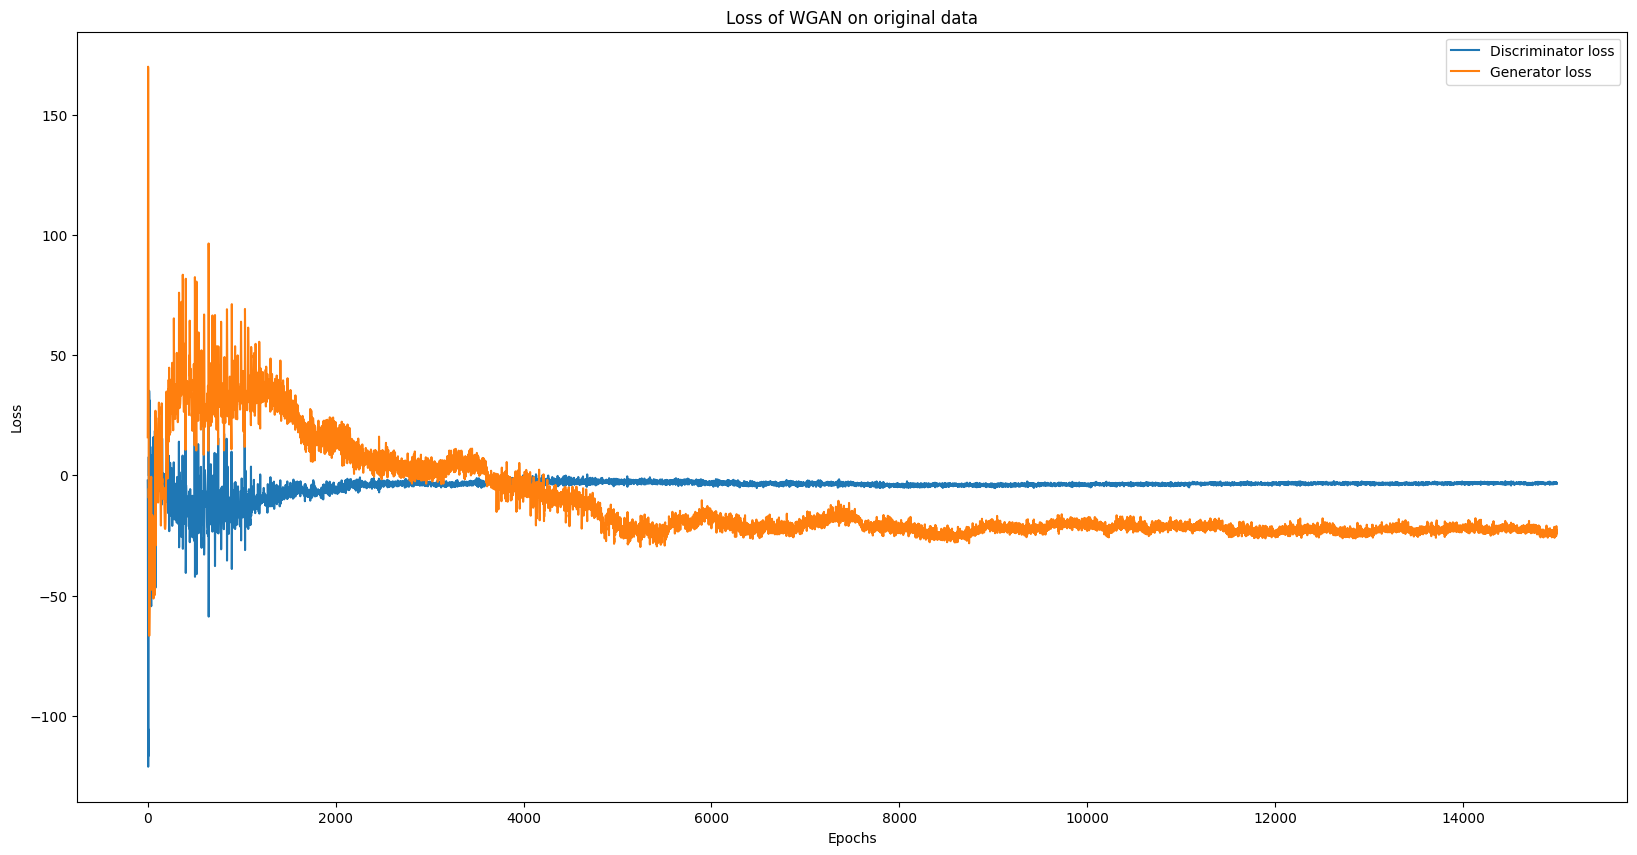

In [11]:
plt.figure(figsize=(20,10))
plt.plot(history["d_loss"])
plt.plot(history["g_loss"])
plt.title("Loss of WGAN on original data")
plt.legend(["Discriminator loss", "Generator loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [12]:
logger.info("Generating data!")
result = syn.synthesize(len(df), seq_len=180)
#result = syn.synthesize(10, seq_len=180)
print(result[0], np.array(result[0]).shape)
#with open("{}/data".format(root_dir), "wb") as f:
#    pickle.dump(result, f)

02/09/2024 03:50:18:INFO:Generating data!
Generating data!


[0.59407485 0.59528506 0.59289646 0.5929621  0.59412545 0.59433687
 0.5964955  0.59695226 0.5984861  0.6005071  0.60214144 0.6019
 0.60193336 0.602234   0.60220826 0.6017581  0.60239124 0.60363066
 0.6036082  0.6040616  0.6050207  0.6066022  0.60674757 0.6070887
 0.6080559  0.60780436 0.6075955  0.6065153  0.6028124  0.6022185
 0.6007111  0.59898555 0.59598815 0.5924127  0.5889524  0.5852394
 0.58209676 0.5793683  0.57718587 0.5724522  0.5698453  0.5673511
 0.5646765  0.561801   0.5587723  0.56834126 0.57084537 0.57827485
 0.5922803  0.60775566 0.6083841  0.60667896 0.60835457 0.6153328
 0.6100135  0.6083987  0.6208027  0.6214441  0.60603285 0.5868964
 0.572954   0.56441885 0.55667126 0.5550737  0.5620891  0.5767479
 0.5956363  0.61122787 0.617782   0.6210928  0.6189671  0.60780144
 0.5984558  0.6056578  0.5991194  0.59403116 0.59123933 0.59221804
 0.5912412  0.5899679  0.61227494 0.6179457  0.62398195 0.6284504
 0.6597409  0.6401522  0.61337173 0.65655184 0.6687709  0.68485075
 0.7077

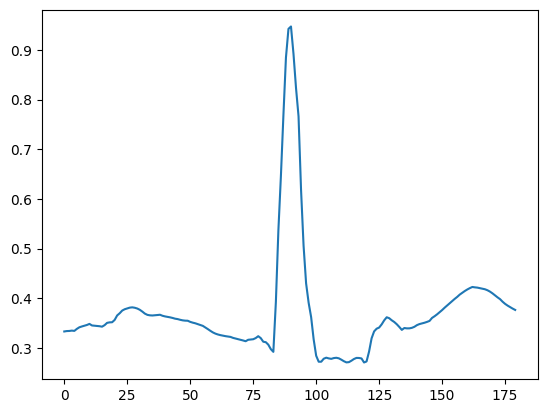

In [13]:
plt.plot(result[123])

In [14]:
pd.DataFrame(result).to_csv(f"data/generated/poll{poll}_normal_train_180_embed{32}_rtsgan.csv")

In [15]:
ae_gen = AutoEncTrainRoutine()

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


loss: 87.357941  [    1/69828]
loss: 9.948500  [10001/69828]
loss: 3.909497  [20001/69828]
loss: 5.030890  [30001/69828]
loss: 5.871005  [40001/69828]
loss: 2.974357  [50001/69828]
loss: 2.818467  [60001/69828]
Epoch 1: train loss = 6.971221442582163, val loss = 6.179494162668408
loss: 5.663132  [    1/69828]
loss: 2.176677  [10001/69828]
loss: 1.786429  [20001/69828]
loss: 1.532391  [30001/69828]
loss: 3.994361  [40001/69828]
loss: 2.010056  [50001/69828]
loss: 1.409336  [60001/69828]
Epoch 2: train loss = 2.8710878050734636, val loss = 5.499889191138636
loss: 0.594569  [    1/69828]
loss: 2.348269  [10001/69828]
loss: 0.760113  [20001/69828]
loss: 2.576416  [30001/69828]
loss: 2.129600  [40001/69828]
loss: 1.779449  [50001/69828]
loss: 0.782523  [60001/69828]
Epoch 3: train loss = 2.2384734900444516, val loss = 5.342904711503175
loss: 1.870712  [    1/69828]
loss: 0.933125  [10001/69828]
loss: 1.425349  [20001/69828]
loss: 1.173346  [30001/69828]
loss: 1.570192  [40001/69828]
loss: 1

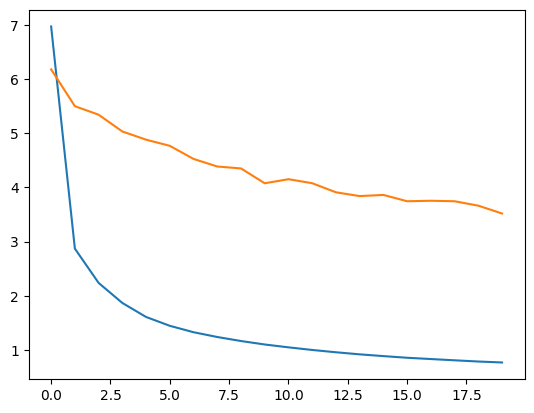

In [16]:
model_name = f"poll{poll}_rtsgan_embed{32}.pth"
if os.path.exists(f"models/{model_name}"):
    ae_gen.load_model(model_name)

else:
    model, history = ae_gen.train_model(train_ds_path=f"data/generated/poll{poll}_normal_train_180_embed{32}_rtsgan.csv", val_ds_path=f"data/poll{poll}_normal_val_180.csv")
    plt.plot(history["train"])
    plt.plot(history["val"])
    ae_gen.save_model(model_name)

In [17]:
pd.DataFrame(history["train"]).to_csv(f"loss_history/poll{poll}_rtsgan_embed32_train.csv")
pd.DataFrame(history["val"]).to_csv(f"loss_history/poll{poll}_rtsgan_embed32_val.csv")

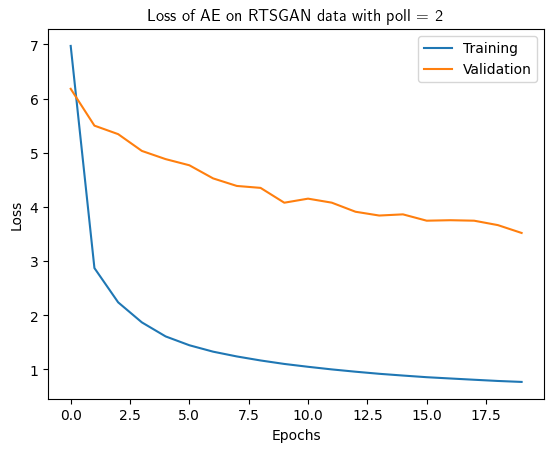

In [18]:
plt.plot(history["train"])
plt.plot(history["val"])
plt.title(f'Loss of AE on RTSGAN data with poll = {poll}', usetex=True)
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [19]:
from util.Evaluator import Evaluator
window_size=180
evaluator = Evaluator(val_normal_path=f"data/poll{poll}_normal_val_{window_size}.csv",
                      val_anomaly_path=f"data/poll{poll}_anomalie_val_{window_size}.csv",
                        test_normal_path=f"data/normal_test{window_size}.csv",
                        test_anomaly_path=f"data/anomalie_test{window_size}.csv", 
                        model=ae_gen.model)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


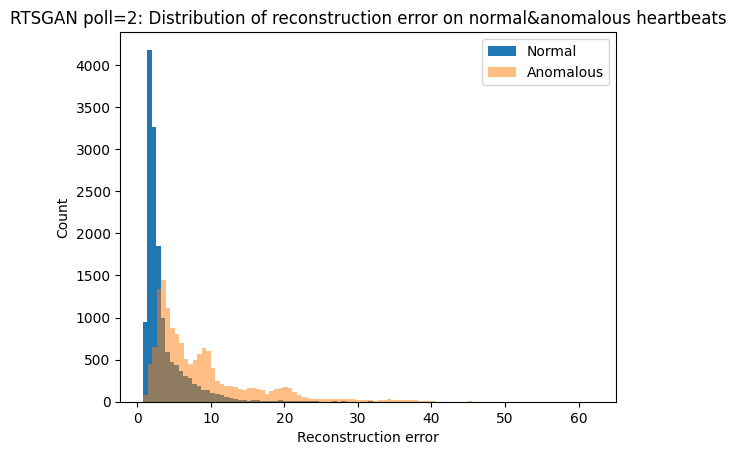

In [20]:
plt.figure()

plt.hist(evaluator.loss_val_normal, bins=100)

plt.title(f"RTSGAN poll={poll}: Distribution of reconstruction error on normal&anomalous heartbeats")

plt.hist(evaluator.loss_val_anomaly, bins=100, alpha=0.5)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")

plt.legend(["Normal", "Anomalous"])

plt.show()

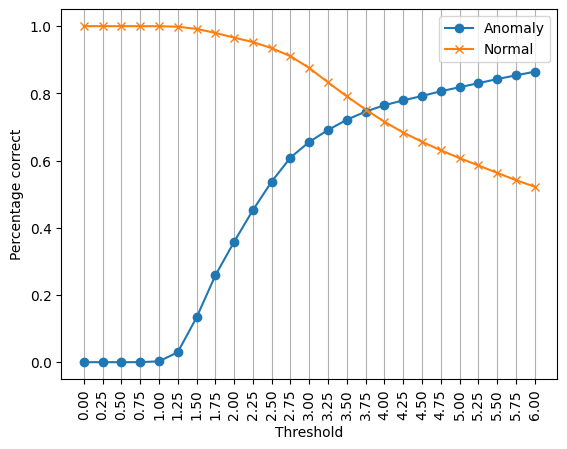

In [21]:
threshold_list = np.linspace(0,6,25)
corr_normal, corr_anomaly = evaluator.find_threshold(threshold_list)
plt.plot(threshold_list, corr_normal, marker="o")
plt.plot(threshold_list, corr_anomaly, marker="x")
plt.xticks(threshold_list, rotation=90)
plt.xlabel("Threshold")
plt.ylabel("Percentage correct")
plt.legend(["Anomaly", "Normal"])
plt.grid(axis="x")
plt.show()

In [22]:
predictions_normal, predictions_anomaly = evaluator.predict_class(6)


In [23]:
evaluator.evaluate(predictions_normal, predictions_anomaly)

TP: 1554
FN: 206
FP: 874
TN: 930
Acc: 0.696969696969697
Precision: 0.6400329489291599
Recall: 0.8829545454545454
F1: 0.7421203438395416
